In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv', sep = ";",index_col= False)

# Создание целевой переменной: 1 если N_claims_year > 1, иначе 0
data['claim_prob'] = (data['N_claims_year'] > 1).astype(int)

# Предобработка данных
# Удаление ненужных столбцов, но НЕ УДАЛЯЕМ Date_start_contract
cols_to_drop = ['ID','Date_last_renewal', 'Date_next_renewal', 
                'Date_lapse', 'N_claims_year', 'Cost_claims_year', 'N_claims_history', 'Value_vehicle', 'Payment', 
                'R_Claims_history', 'Max_products', 'Cylinder_capacity', 'N_doors', 'Type_fuel', 'Length', 'Weight']
data = data.drop(columns=cols_to_drop)

# Преобразуем Date_start_contract в datetime ДО любой обработки
data['Date_start_contract'] = pd.to_datetime(data['Date_start_contract'], errors='coerce')#pd.to_datetime(data['Date_start_contract'], errors='coerce')

C:\Users\andre\AppData\Local\Temp\ipykernel_772\2066037212.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv', sep = ";",index_col= False)


In [3]:
# 1. Сначала обработать ВСЕ датовые колонки, если они существуют
date_columns = ['Date_birth', 'Date_driving_licence']

# Создаем список существующих датовых колонок
existing_date_columns = [col for col in date_columns if col in data.columns]

# Проверим, какие датовые колонки нашлись
print("Существующие датовые колонки для обработки:", existing_date_columns)

if not existing_date_columns:
    print("Предупреждение: Датовые колонки не найдены в DataFrame.")
else:
    for col in existing_date_columns:
        data[col] = pd.to_datetime(data[col], format='%d/%m/%Y', errors='coerce')

    # 2. Извлечь числовые признаки из существующих дат
    reference_date = pd.to_datetime('2019-12-31')
    
    if 'Date_birth' in data.columns:
        data['Age'] = (reference_date - data['Date_birth']).dt.days // 365
    
    if 'Date_driving_licence' in data.columns:
        data['Driving_experience'] = (reference_date - data['Date_driving_licence']).dt.days // 365

    

# 2. Извлечь числовые признаки из дат
reference_date = pd.to_datetime('2019-12-31')
data['Age'] = (reference_date - data['Date_birth']).dt.days // 365
data['Driving_experience'] = (reference_date - data['Date_driving_licence']).dt.days // 365

# 3. Удалить исходные датовые колонки
data = data.drop(columns=date_columns)
data = data.drop(columns=existing_date_columns, errors='ignore')
# 4. Обработать категориальные переменные
# categorical_cols = ['Type_fuel']
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col].astype(str))
#     label_encoders[col] = le

# 5. Убедиться, что все данные числовые
data = data.apply(pd.to_numeric, errors='coerce')

# 6. Обработка пропущенных значений
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data)
data = pd.DataFrame(data_imputed, columns=data.columns)

Существующие датовые колонки для обработки: ['Date_birth', 'Date_driving_licence']


In [4]:
# Разделение на признаки и целевую переменную
X = data.drop(columns=['claim_prob'])
y = data['claim_prob']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
# Разделение по дате
# train_mask = data['Date_start_contract'] < '2017-07-01'
# X_train = data[train_mask].drop(columns=['claim_prob', 'Date_start_contract'])
# y_train = data[train_mask]['claim_prob']
# X_test = data[~train_mask].drop(columns=['claim_prob', 'Date_start_contract'])
# y_test = data[~train_mask]['claim_prob']

# # Масштабирование признаков
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Преобразование в тензоры PyTorch
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [5]:
print(X_train.head())

       Date_start_contract  Distribution_channel  Seniority  \
72716        -9.223372e+18                   0.0       15.0   
95053         1.391904e+18                   1.0        5.0   
98446        -9.223372e+18                   1.0        3.0   
41836        -9.223372e+18                   1.0        1.0   
16050        -9.223372e+18                   1.0        3.0   

       Policies_in_force  Max_policies  Lapse  Premium  Type_risk  Area  \
72716                1.0           4.0    1.0   391.64        2.0   1.0   
95053                1.0           3.0    0.0   327.81        2.0   0.0   
98446                1.0           1.0    0.0   460.39        3.0   1.0   
41836                1.0           1.0    0.0   222.65        3.0   0.0   
16050                2.0           3.0    0.0   465.21        3.0   0.0   

       Second_driver  Year_matriculation  Power   Age  Driving_experience  
72716            0.0              2008.0  100.0  42.0                19.0  
95053            0

In [ ]:
# # Создание нейронной сети
# class InsuranceNet(nn.Module):
#     def __init__(self, input_size):
#         super(InsuranceNet, self).__init__()
#         self.layer1 = nn.Linear(input_size, 64)
#         self.layer2 = nn.Linear(64, 32)
#         self.layer3 = nn.Linear(32, 16)
#         # self.layer4 = nn.Linear(48, 36)
#         # self.layer5 = nn.Linear(36, 24)
#         # self.layer6 = nn.Linear(24, 16)
#         self.output = nn.Linear(16,1)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.
        
#     def forward(self, x):
#         x = self.relu(self.layer1(x))
#         x = self.relu(self.layer2(x))
#         x = self.relu(self.layer3(x))
#         x = self.relu(self.layer4(x))
#         x = self.relu(self.layer5(x))
#         x = self.relu(self.layer6(x))
#         x = self.sigmoid(self.output(x))
#         return x

# # Инициализация модели
# input_size = X_train_tensor.shape[1]
# print(input_size)
# model = InsuranceNet(input_size)

# # Определение функции потерь и оптимизатора
# criterion = nn.BCELoss()
# # class FocalLoss(nn.Module):
# #     def __init__(self, alpha=1, gamma=2):
# #         super(FocalLoss, self).__init__()
# #         self.alpha = alpha
# #         self.gamma = gamma
        
# #     def forward(self, inputs, targets):
# #         BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
# #         pt = torch.exp(-BCE_loss)
# #         focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
# #         return focal_loss

# # criterion = FocalLoss(alpha=0.25, gamma=2)
# #criterion = nn.BCEWithLogitsLoss()
# #optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


14


In [6]:
import torch
import torch.nn as nn

# Создание нейронной сети
class InsuranceNet(nn.Module):
    def __init__(self, input_size):
        super(InsuranceNet, self).__init__()
        
        # --- Слои ---
        self.layer1 = nn.Linear(input_size, 72)
        self.bn1 = nn.BatchNorm1d(72)
        self.dropout1 = nn.Dropout(0.2)
        
        self.layer2 = nn.Linear(72, 36)
        self.bn2 = nn.BatchNorm1d(36)
        self.dropout2 = nn.Dropout(0.1)

        self.layer3 = nn.Linear(36, 18)
        #self.bn3 = nn.BatchNorm1d(16)
        
        self.output = nn.Linear(18, 1)
        
        # --- Активации ---
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # 1-й слой
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # 2-й слой
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu(x)
        #x = self.dropout2(x)
        # 3-й слой
        x = self.layer3(x)
        #x = self.bn3(x)
        x = self.relu(x)

        # Выход (вероятность от 0 до 1)
        x = self.sigmoid(self.output(x))
        return x

# --- Инициализация модели ---
input_size = X_train_tensor.shape[1]
model = InsuranceNet(input_size)

# --- Функция потерь и оптимизатор ---
criterion = nn.BCELoss()  # можно заменить на FocalLoss при сильном дисбалансе
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


In [7]:
# Обучение модели
epochs = 500
losses =[]
epochs_plt =[]
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        losses.append(loss.item())
        epochs_plt.append(epoch+1)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/500], Loss: 0.6171
Epoch [20/500], Loss: 0.5426
Epoch [30/500], Loss: 0.4744
Epoch [40/500], Loss: 0.4148
Epoch [50/500], Loss: 0.3664
Epoch [60/500], Loss: 0.3311
Epoch [70/500], Loss: 0.3100
Epoch [80/500], Loss: 0.3005
Epoch [90/500], Loss: 0.2958
Epoch [100/500], Loss: 0.2938
Epoch [110/500], Loss: 0.2928
Epoch [120/500], Loss: 0.2922
Epoch [130/500], Loss: 0.2916
Epoch [140/500], Loss: 0.2910
Epoch [150/500], Loss: 0.2908
Epoch [160/500], Loss: 0.2904
Epoch [170/500], Loss: 0.2899
Epoch [180/500], Loss: 0.2897
Epoch [190/500], Loss: 0.2892
Epoch [200/500], Loss: 0.2890
Epoch [210/500], Loss: 0.2888
Epoch [220/500], Loss: 0.2890
Epoch [230/500], Loss: 0.2882
Epoch [240/500], Loss: 0.2877
Epoch [250/500], Loss: 0.2876
Epoch [260/500], Loss: 0.2877
Epoch [270/500], Loss: 0.2877
Epoch [280/500], Loss: 0.2876
Epoch [290/500], Loss: 0.2871
Epoch [300/500], Loss: 0.2869
Epoch [310/500], Loss: 0.2870
Epoch [320/500], Loss: 0.2864
Epoch [330/500], Loss: 0.2864
Epoch [340/500], Lo

Text(0, 0.5, 'Loss function')

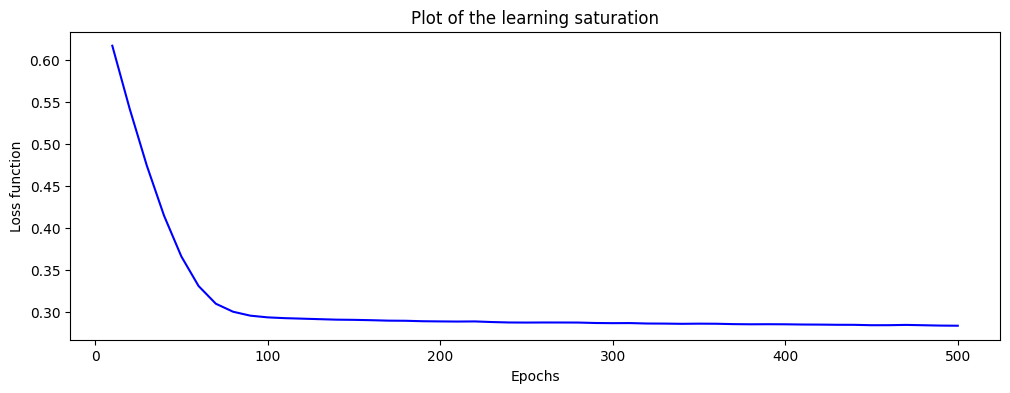

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(epochs_plt, losses, label='Plot of the learning saturation', color='blue')
plt.title('Plot of the learning saturation')
plt.xlabel('Epochs')
plt.ylabel('Loss function')

In [10]:
# Оценка модели
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor).numpy()
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Метрики
roc_auc = roc_auc_score(y_test, y_pred_proba)
mae = mean_absolute_error(y_test, y_pred_proba)

print(f'ROC-AUC: {roc_auc:.4f}')
print(f'MAE: {mae:.4f}')

with torch.no_grad():
    train_proba = torch.sigmoid(model(X_train_tensor)).numpy().flatten()
train_auc = roc_auc_score(y_train, train_proba)
print(f"\nROC-AUC на тренировочных данных: {train_auc:.4f}")
diff = train_auc-roc_auc
print(f"\nDifference:  {diff:.4f}")

ROC-AUC: 0.7208
MAE: 0.1724

ROC-AUC на тренировочных данных: 0.7421

Difference:  0.0213


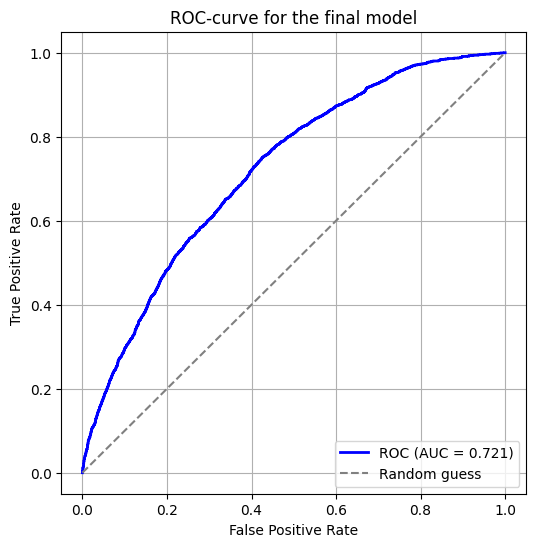

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# вычисляем координаты ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# вычисляем площадь под кривой
roc_auc = roc_auc_score(y_test, y_pred_proba)

# строим график
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve for the final model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [53]:
# from torchviz import make_dot

# # Пример: визуализация твоей модели
# x = torch.randn(1, input_size)  # пример входа
# y = model(x)

# # Генерация схемы
# make_dot(y, params=dict(model.named_parameters())).render("insurance_net", format="png")

torch.save(model, "insurance_model.pt")
import netron
netron.start("insurance_model.pt")
from torchinfo import summary

summary(model, input_size=(64, input_size))  # batch=64, признаков 14

Serving 'insurance_model.pt' at http://localhost:8080


Layer (type:depth-idx)                   Output Shape              Param #
InsuranceNet                             [64, 1]                   --
├─Linear: 1-1                            [64, 72]                  1,080
├─BatchNorm1d: 1-2                       [64, 72]                  144
├─ReLU: 1-3                              [64, 72]                  --
├─Dropout: 1-4                           [64, 72]                  --
├─Linear: 1-5                            [64, 36]                  2,628
├─BatchNorm1d: 1-6                       [64, 36]                  72
├─ReLU: 1-7                              [64, 36]                  --
├─Linear: 1-8                            [64, 18]                  666
├─ReLU: 1-9                              [64, 18]                  --
├─Linear: 1-10                           [64, 1]                   19
├─Sigmoid: 1-11                          [64, 1]                   --
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
Total mul

In [12]:
import os
import pickle
with open('my_NN.pkl','wb') as f:
    pickle.dump(model,f)
    pcl1 = pickle.dump(model,f)